<a href="https://colab.research.google.com/github/poolGolez/tf-playground/blob/main/udacity/Udacity_Exercise_03%5D_CNN_Rock%2C_Paper%2C_Scissors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt
import os
import math

TARGET_IMAGE_SHAPE=(150,150)
BATCH_SIZE=100

# Retrieve dataset

In [ ]:
def retrieve_dataset():
  def load_training_data():
    global TRAIN_TOTAL
    training_dataset_url = 'https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip'
    training_zip_file_path = tf.keras.utils.get_file('training_set.zip', origin=training_dataset_url, extract=True)
    training_dataset_dir = os.path.join(os.path.dirname(training_zip_file_path), 'rps')

    rock_count      = len(os.listdir(os.path.join(training_dataset_dir, 'rock')))
    scissors_count  = len(os.listdir(os.path.join(training_dataset_dir, 'scissors')))
    paper_count     = len(os.listdir(os.path.join(training_dataset_dir, 'paper')))
    TRAIN_TOTAL = rock_count + paper_count + scissors_count
    print('[Training]Rock count:', rock_count)
    print('[Training]Paper count:', paper_count)
    print('[Training]Scissors count:', scissors_count)
    print('[Training]Total count:', rock_count + paper_count + scissors_count)

    image_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        directory=training_dataset_dir,
        target_size=TARGET_IMAGE_SHAPE,
        class_mode='categorical',
        shuffle=True,
        batch_size=BATCH_SIZE)
    return image_generator

  def load_validation_data():
    global VALIDATION_TOTAL
    test_dataset_url = 'https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip'
    test_zip_file_path = tf.keras.utils.get_file('validation_set.zip', origin=test_dataset_url, extract=True)
    test_dataset_dir = os.path.join(os.path.dirname(test_zip_file_path), 'rps-test-set')

    # !find $test_dataset_dir -type d -print
    rock_count      = len(os.listdir(os.path.join(test_dataset_dir, 'rock')))
    scissors_count  = len(os.listdir(os.path.join(test_dataset_dir, 'scissors')))
    paper_count     = len(os.listdir(os.path.join(test_dataset_dir, 'paper')))
    VALIDATION_TOTAL = rock_count + paper_count + scissors_count
    print('[Validation]Rock count:', rock_count)
    print('[Validation]Paper count:', paper_count)
    print('[Validation]Scissors count:', scissors_count)
    print('[Validation]Total count:', VALIDATION_TOTAL)

    image_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        directory=test_dataset_dir,
        target_size=TARGET_IMAGE_SHAPE,
        class_mode='categorical',
        shuffle=False,
        batch_size=BATCH_SIZE
    )
    return image_generator

  return (load_training_data(), load_validation_data())

training_image_generator, validation_image_generator = retrieve_dataset()
CLASS_NAMES = list({v:k for k,v in training_image_generator.class_indices.items()}.values())
TRAIN_TOTAL

[Training]Rock count: 840
[Training]Paper count: 840
[Training]Scissors count: 840
[Training]Total count: 2520
Found 2520 images belonging to 3 classes.
[Validation]Rock count: 124
[Validation]Paper count: 124
[Validation]Scissors count: 124
[Validation]Total count: 372
Found 372 images belonging to 3 classes.


2520

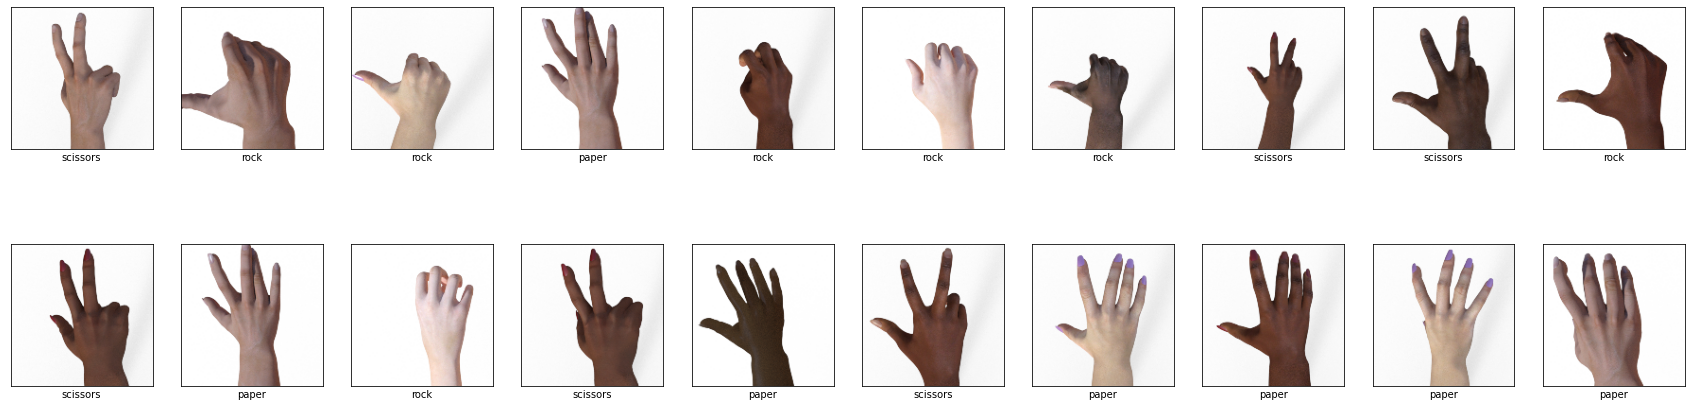

In [ ]:
def peek_samples(image_generator, title=''):
  sample_images, sample_labels = next(image_generator)
  plt.figure(figsize=(30,8))
  plt.title(title)

  for index, (image, label) in enumerate(list(zip(sample_images,sample_labels))[:20]):
    plt.subplot(2, 10, index+1)
    plt.xticks([])
    plt.yticks([])

    class_name = CLASS_NAMES[np.argmax(label)]
    plt.xlabel(class_name)
    plt.imshow(image)
  plt.show()

  image_generator.reset()

peek_samples(training_image_generator, 'Training set')
# peek_samples(validation_image_generator, 'Validation set')

# Assemble the model

In [ ]:
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150,150,3)),
  tf.keras.layers.MaxPooling2D((2,2)),

  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
  tf.keras.layers.MaxPooling2D((2,2)),
  
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2,2)),
  
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2,2)),
  
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D((2,2)),

  tf.keras.layers.Flatten(),

  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(3)
])

model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics='accuracy')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       7

In [ ]:
EPOCHS = 10
history = model.fit_generator(training_image_generator,
                    epochs=EPOCHS, 
                    steps_per_epoch=int(np.ceil(TRAIN_TOTAL/BATCH_SIZE)),
                    validation_data=validation_image_generator,
                    validation_steps=int(np.ceil(VALIDATION_TOTAL/BATCH_SIZE))
          )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
26/26 [==============================] - 42s 387ms/step - loss: 0.7742 - accuracy: 0.6345 - val_loss: 0.8044 - val_accuracy: 0.7634
Epoch 2/10
26/26 [==============================] - 9s 334ms/step - loss: 0.1272 - accuracy: 0.9619 - val_loss: 1.0830 - val_accuracy: 0.8145
Epoch 3/10
26/26 [==============================] - 9s 337ms/step - loss: 0.0112 - accuracy: 0.9984 - val_loss: 1.3536 - val_accuracy: 0.8306
Epoch 4/10
26/26 [==============================] - 9s 340ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 1.5612 - val_accuracy: 0.8280
Epoch 5/10
26/26 [==============================] - 9s 334ms/step - loss: 2.7443e-04 - accuracy: 1.0000 - val_loss: 1.6301 - val_accuracy: 0.8387
Epoch 6/10
26/26 [==============================] - 9s 344ms/step - loss: 1.6332e-04 - accuracy: 1.0000 - val_loss: 1.7224 - val_accuracy: 0.8360
Epoch 7/10
26/26 [==============================] - 9s 332ms/step - loss: 1.1919e-04 - accuracy: 1.0000 - val_loss: 1.7716 - val_accuracy: 

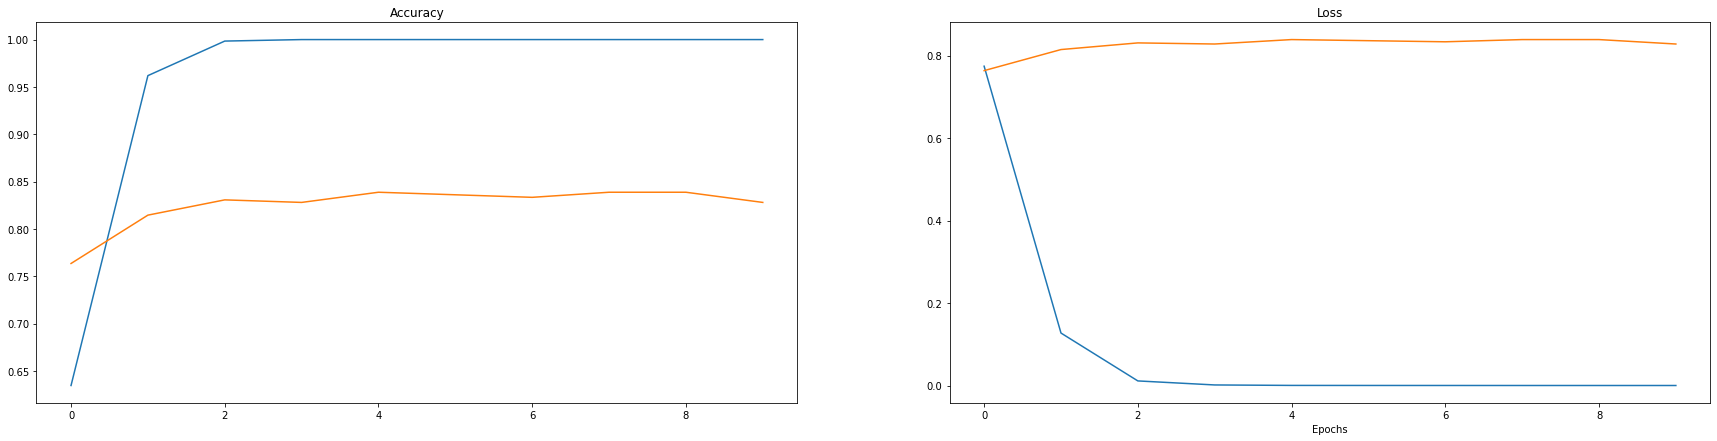

In [ ]:
plt.figure(figsize=(30,7))

plt.subplot(1,2,1)
plt.plot(history.epoch, history.history['accuracy'])
plt.plot(history.epoch, history.history['val_accuracy'])
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.epoch, history.history['loss'])
plt.plot(history.epoch, history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.title("Loss")

plt.show()

<bound method BaseResourceVariable.numpy of <tf.Variable 'conv2d/kernel:0' shape=(3, 3, 3, 16) dtype=float32, numpy=
array([[[[-5.08949794e-02,  8.29632115e-03,  1.01835780e-01,
           3.46216783e-02,  9.58297029e-02, -3.23835239e-02,
          -1.63917348e-01,  8.41551721e-02,  1.83535144e-01,
           1.27390712e-01,  1.24226965e-01,  1.03338093e-01,
           5.15559092e-02,  5.98042943e-02, -8.76245946e-02,
           1.56898171e-01],
         [ 8.05489346e-02,  1.58961430e-01, -1.07382290e-01,
          -2.66789272e-02, -5.43671139e-02,  8.20704028e-02,
           1.78762227e-01,  1.38928831e-01, -1.49286598e-01,
           1.34480774e-01, -2.51379572e-02, -6.92147166e-02,
          -3.63047831e-02,  1.17942534e-01,  1.47101924e-01,
           3.84141132e-02],
         [-1.32292956e-01, -5.77027793e-04,  5.48517564e-05,
          -1.87170386e-01,  1.45433769e-01,  5.06432950e-02,
           1.29130900e-01, -9.57383960e-02,  1.76865816e-01,
          -8.94397870e-02,  9.3530